In [0]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
sns.set()

import pprint as pp
from joblib import dump

In [0]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


# The Data


>The Multi-Domain Sentiment Dataset contains product reviews taken from Amazon.com from many product types (domains). Some domains (books and dvds) have hundreds of thousands of reviews. Others (musical instruments) have only a few hundred. Reviews contain star ratings (1 to 5 stars) that can be converted into binary labels if needed. This page contains some descriptions about the data. If you have questions, please email Mark Dredze or John Blitzer. 

http://www.cs.jhu.edu/~mdredze/datasets/sentiment/

"""This script parse amazon books revies xml to a csv file
parse_xml2csv()
"""

from tqdm import tqdm
import csv

def parse_xml2csv(): 
    dataset_file = './data/amazon_reviews/sorted_data/books/unlabeled.review'
    output_file = './data/amazon_reviews/csv/books_reviews.csv'
    
    def _active_tag(tag):
        if f'<{tag}>' in line:
            rw[tag] = ''
            return tag
        elif f'</{tag}>' in line:
            return '#end_tag#'
    
    # columns = ['product_name', 'rating', 'title', 'review_text']
    columns = ['rating', 'review_text']
    active_tag = None
    
    csvfile = open(output_file, 'w', newline='')
    csvwriter = csv.DictWriter(csvfile, fieldnames=columns)
    csvwriter.writeheader()
    
    with open(dataset_file, 'r', encoding='utf-8', errors='ignore') as fp:
        for line in tqdm(fp):
            if '<review>' in line:
                rw = {}
                continue
            elif '</review>' in line:
                csvwriter.writerow(rw)
            
            tags = map(_active_tag, columns)
            tag = next((i for i in tags if i is not None), None)
            
            if tag == '#end_tag#':
                rw[active_tag] = rw[active_tag].strip()
                active_tag = None
                continue
            elif tag is not None:
                active_tag = tag
                continue
            
            if active_tag is not None:
                rw[active_tag] += line
    
    csvfile.close()

# Running the parser    
parse_xml2csv()

In [0]:
csv_file = '../content/gdrive/My Drive/NLP-data/books_reviews.csv'
df = pd.read_csv(csv_file)

In [0]:
df['rating'] = df['rating'].astype('category')

In [0]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 973194 entries, 0 to 973193
Data columns (total 2 columns):
rating         973194 non-null category
review_text    973183 non-null object
dtypes: category(1), object(1)
memory usage: 8.4+ MB


In [0]:
df.head(10)

,rating,review_text
0,5.0,This all-Spanish handbook for parents with new...
1,5.0,McCarthy's writing and portrayal of Lester Bal...
2,2.0,Do you giggle uncontrollably when poking corps...
3,5.0,I was initiated into the world of Cormac McCar...
4,4.0,I cannot speak to the literary points in the n...
5,4.0,There is no denying the strain of Faulkner tha...
6,5.0,I have read sevral of McCarthy's other novels....
7,5.0,This is a gripping novel that probes the bread...
8,1.0,"If you're considering buying the Peter Smith ""..."
9,2.0,What I didn't realise when I ordered this is t...


In [0]:
sample = df[df['rating'] == 2].sample(1)
pp.pprint(sample['review_text'].values[0])
print('-'*100)
print('Number of words: %d' % sample['review_text'].str.split().apply(len))
print('Rating: %d stars' % sample['rating'].values[0])

("I must admit I only bought this because Allison DuBois' web site fires a "
 "broadside at the author. I had to know what had her all riled up. You don't "
 "need a 'gift' to see that it's probably annoyance that Dr Schwartz has "
 'successfully tied himself to her famous apron strings and made some tidy '
 "coin from cashing in on her fame. I' be annoyed too, especially if I had "
 "written such a thoroughly disappointing book as Mrs Dubois' Don't Kiss Them "
 "Goodbye. Even with all her powers she couldn't 'see' the benefit of "
 'collaborating with a skilled writer. Dr Schwartz, on the other hand, has '
 "teamed up with William L Simon who manages to maintain the reader's interest "
 'through a story that is stretched over far too many pages. Although I found '
 'myself skimming at times I did read it through to the end. \n'
 'I hoped for more, a lot more. I found myself looking at the back cover '
 'hoping for a free voucher for the rest of the book when it is written. No, '
 'jus

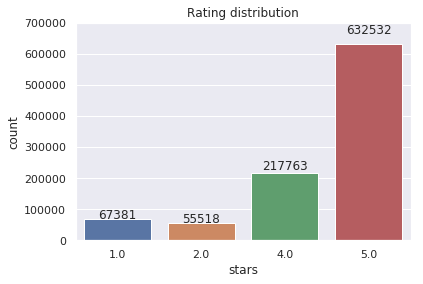

In [0]:
def plot_rating_dist(df, x='rating', title='Rating distribution', xlabel='stars', ylim=700000):
    ax = sns.countplot(x=x, data=df)
    ax.set_title(title)
    ax.set_xlabel(xlabel)
    for rect in ax.containers[0]:
        tw = rect.get_width() / 2.
        tx = rect.get_x() + tw
        height = rect.get_height()
        ty = 1.05 * height
        ax.text(tx, ty, height, ha='center')

    ax.set_ylim(0, ylim)
    
plot_rating_dist(df)

In [0]:
def binary_labels(df, min_set=None):
 
    # Cleanning data set
    count = df['review_text'].str.len()
    df = df[(count > 3) | (count < 4000)].copy()
    
    # Equilize dataset sample size
    if min_set is None:
        min_set = df['rating'].value_counts().min() * 4
    
    # Split rating 1.0, 2.0 as negative reviews
    rating_1 = df[df['rating'] == 1.0].iloc[:min_set // 4]
    rating_2 = df[df['rating'] == 2.0].iloc[:min_set // 4]
    negative_reviews = pd.concat([rating_1, rating_2])
    negative_reviews['label'] = 0
    
    # Split rating 4.0, 5.0 as positive reviews
    rating_4 = df[df['rating'] == 4.0].iloc[:min_set // 4]
    rating_5 = df[df['rating'] == 5.0].iloc[:min_set // 4]
    positive_reviews = pd.concat([rating_4, rating_5])
    positive_reviews['label'] = 1
    
    dataset = pd.concat([negative_reviews, positive_reviews])
    dataset.sort_index(inplace=True)
    
    return dataset

dataset = binary_labels(df,  min_set=50000)

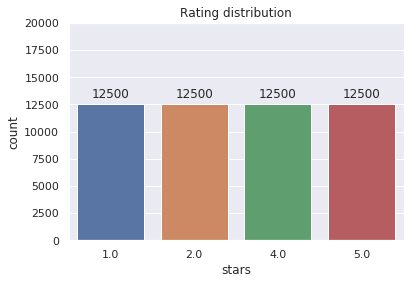

In [0]:
plot_rating_dist(dataset, ylim=20000)

texts size:  50000
labels size:  50000


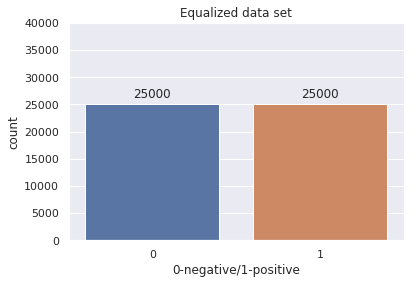

In [0]:
texts = dataset['review_text'].astype(str)
labels = dataset['label'].astype('int32')

print('texts size: ', texts.size)
print('labels size: ', labels.size)

plot_rating_dist(pd.concat([texts, labels], axis=1), x='label', title='Equalized data set', xlabel='0-negative/1-positive', ylim=40000)

# Preprocessing Text data

In [0]:
from keras.preprocessing.sequence import pad_sequences
import numpy as np

In [0]:
MAX_NUM_FEATURES = 20000
NGRAN_RANGE = 1
MAX_SEQUENCE_LENGTH = 400
VALIDATION_SPLIT = .1

In [0]:
from keras.preprocessing import text

tokenizer = text.Tokenizer(num_words=MAX_NUM_FEATURES)
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)
word_index = tokenizer.word_index

print('Found %s unique tokens.' % len(word_index))

Found 96740 unique tokens.


In [0]:
dump(tokenizer, '../content/gdrive/My Drive/NLP-data/tokenizer_fasttext.joblib')

['../content/gdrive/My Drive/NLP-data/tokenizer_fasttext.joblib']

In [0]:
print(texts[4164])
pp.pprint(sequences[4164], width=200, compact=True)

thank you for a great book
[1372, 19, 13, 5, 89, 12]


In [0]:
print(len(sequences), 'sequences')
print('Average train sequence length: %d' % np.mean(list(map(len, sequences))))

50000 sequences
Average train sequence length: 168


In [0]:
def create_ngram_set(input_list, ngram_value=2):
    """
    Extract a set of n-grams from a list of integers.
    >>> create_ngram_set([1, 4, 9, 4, 1, 4], ngram_value=2)
    {(4, 9), (4, 1), (1, 4), (9, 4)}
    >>> create_ngram_set([1, 4, 9, 4, 1, 4], ngram_value=3)
    [(1, 4, 9), (4, 9, 4), (9, 4, 1), (4, 1, 4)]
    """
    return set(zip(*[input_list[i:] for i in range(ngram_value)]))


def add_ngram(sequences, token_indice, ngram_range=2):
    """
    Augment the input list of list (sequences) by appending n-grams values.
    Example: adding bi-gram
    >>> sequences = [[1, 3, 4, 5], [1, 3, 7, 9, 2]]
    >>> token_indice = {(1, 3): 1337, (9, 2): 42, (4, 5): 2017}
    >>> add_ngram(sequences, token_indice, ngram_range=2)
    [[1, 3, 4, 5, 1337, 2017], [1, 3, 7, 9, 2, 1337, 42]]
    Example: adding tri-gram
    >>> sequences = [[1, 3, 4, 5], [1, 3, 7, 9, 2]]
    >>> token_indice = {(1, 3): 1337, (9, 2): 42, (4, 5): 2017, (7, 9, 2): 2018}
    >>> add_ngram(sequences, token_indice, ngram_range=3)
    [[1, 3, 4, 5, 1337, 2017], [1, 3, 7, 9, 2, 1337, 42, 2018]]
    """
    new_sequences = []
    for input_list in sequences:
        new_list = input_list[:]
        for ngram_value in range(2, ngram_range + 1):
            for i in range(len(new_list) - ngram_value + 1):
                ngram = tuple(new_list[i:i + ngram_value])
                if ngram in token_indice:
                    new_list.append(token_indice[ngram])
        new_sequences.append(new_list)

    return new_sequences

In [0]:
len(sequences)

50000

In [0]:
if NGRAN_RANGE > 1:
    ngram_set = set()
    for input_list in sequences:
        for i in range(2, NGRAN_RANGE + 1):
            set_of_ngram = create_ngram_set(input_list, ngram_value=i)
            ngram_set.update(set_of_ngram)
    
    # Dictionary mapping n-gram token to a unique integer.
    # Integer values are greater than max_features in order
    # to avoid collision with existing features.        
    token_indice = {v: k + MAX_NUM_FEATURES for k, v in enumerate(ngram_set)}
    indice_token = {token_indice[k]: k for k in token_indice}
    
    # Update MAX_NUM_FEATURES
    MAX_NUM_FEATURES = np.max(list(indice_token.keys())) + 1
    print('Update MAX_NUM_FEATURES %d' % MAX_NUM_FEATURES)
    
    # Augument sequences with the new features
    sequences = add_ngram(sequences, token_indice, NGRAN_RANGE)
    print(len(sequences), 'sequences')
    print('Average train sequence length: %d' % np.mean(list(map(len, sequences))))

Update MAX_NUM_FEATURES 1248043
50000 sequences
Average train sequence length: 335


In [0]:
dump(token_indice, '../content/gdrive/My Drive/NLP-data/token_indice_fasttext.joblib')

['../content/gdrive/My Drive/NLP-data/token_indice_fasttext.joblib']

In [0]:
data = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH)

In [0]:
pp.pprint(data[0].tolist(), width=200, compact=True)

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 32, 2483, 5241, 13, 689, 15, 104, 3224, 51, 1259, 1526, 13, 91, 1545, 30, 5, 3339, 882,
 2337,

In [0]:
# Split the date into train and validation sets
num_validation_samples = int(VALIDATION_SPLIT * data.shape[0])

X_train = data[:-num_validation_samples]
y_train = labels[:-num_validation_samples]
X_val = data[-num_validation_samples:]
y_val = labels[-num_validation_samples:]

In [0]:
print('X_train shape:', X_train.shape)
print('X_val shape:', X_val.shape)
print('y_train shape:', y_train.shape, 'type', y_train.dtype)
print('y_val shape:', y_val.shape, 'type', y_val.dtype)

X_train shape: (45000, 400)
X_val shape: (5000, 400)
y_train shape: (45000,) type int32
y_val shape: (5000,) type int32


# Fasttext Model

In [0]:
from keras.models import Sequential
from keras.layers import Embedding, GlobalAveragePooling1D, Dense
from keras.callbacks import ModelCheckpoint

In [0]:
def fasttext_model():
    model = Sequential()
    model.add(Embedding(input_dim=MAX_NUM_FEATURES,
                        output_dim=100,
                        input_length=MAX_SEQUENCE_LENGTH))
    model.add(GlobalAveragePooling1D())
    model.add(Dense(1, activation='sigmoid'))
    return model

In [0]:
model = fasttext_model()
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 400, 100)          2000000   
_________________________________________________________________
global_average_pooling1d_2 ( (None, 100)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 101       
Total params: 2,000,101
Trainable params: 2,000,101
Non-trainable params: 0
_________________________________________________________________


In [0]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [0]:
%%time

history = model.fit(X_train, y_train,
                    batch_size=128,
                    epochs=20,
                    validation_data=(X_val, y_val))

Train on 45000 samples, validate on 5000 samples
Epoch 1/20
45000/45000 [==============================] - 23s 522us/step - loss: 0.1345 - acc: 0.9565 - val_loss: 0.3790 - val_acc: 0.8654
Epoch 2/20
45000/45000 [==============================] - 23s 509us/step - loss: 0.1269 - acc: 0.9591 - val_loss: 0.3561 - val_acc: 0.8776
Epoch 3/20
45000/45000 [==============================] - 23s 516us/step - loss: 0.1199 - acc: 0.9626 - val_loss: 0.3956 - val_acc: 0.8686
Epoch 4/20
45000/45000 [==============================] - 23s 505us/step - loss: 0.1144 - acc: 0.9632 - val_loss: 0.4152 - val_acc: 0.8620
Epoch 5/20
45000/45000 [==============================] - 23s 516us/step - loss: 0.1082 - acc: 0.9658 - val_loss: 0.4313 - val_acc: 0.8612
Epoch 6/20
45000/45000 [==============================] - 23s 520us/step - loss: 0.1025 - acc: 0.9678 - val_loss: 0.4149 - val_acc: 0.8650
Epoch 7/20
45000/45000 [==============================] - 23s 507us/step - loss: 0.0978 - acc: 0.9699 - val_loss: 0.5

In [0]:
def plot_results(history):
    # Plot training & validation accuracy values
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper left')
    plt.show()

    # Plot training & validation loss values
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper left')
    plt.show()

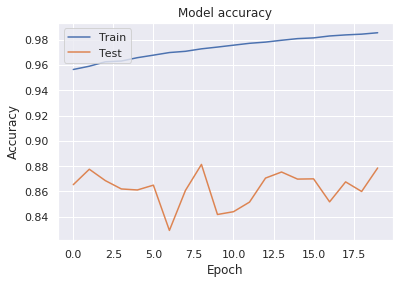

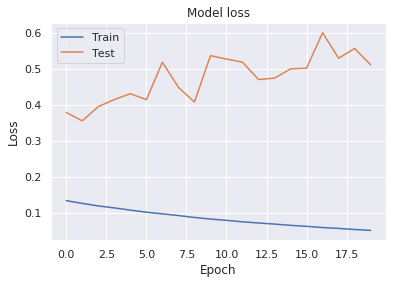

In [0]:
plot_results(history)

In [0]:
model.save(filepath='../content/gdrive/My Drive/NLP-data/Fasttext_ng1_100emb_model_weights_last_epoch.hdf5')
print('DONE')

DONE
